In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from scipy.optimize import minimize
from tqdm import tqdm
from collections import defaultdict

In [2]:
task_data = pd.read_csv('PD_data_choice.csv')

## BRL

### Model fitting

In [19]:
def pd_brl_loglikelihood(sub_data, beta_param, bias, gamma_pos, gamma_neg):
    """
    Bayesian Reinforcement Learning log-likelihood function for Iterative Prisoner's Dilemma
    
    Parameters:
    sub_data: DataFrame with subject data (80 rounds per subject)
    beta_param: softmax temperature parameter for the player
    bias: bias parameter
    gamma_pos: learning rate for cooperative outcomes
    gamma_neg: learning rate for defective outcomes
    
    Returns:
    bayes_ll: negative log-likelihood
    choice_probs: Fitted choice probabilities for each trial
    mews: Estimated mean probabilities of cooperating for each trial
    """
    
    # Read trial parameters
    trial = sub_data['round_number'].values
    p1_choice = sub_data['p1_choice'].values
    p2_choice = sub_data['p2_choice'].values
    
    # Number of trials
    num_trials = len(trial)
    
    # Initialize priors for each 'player type': uniform probability
    a_init = 1.01
    b_init = 1.01
    
    # Set alpha and beta for each 'player type'
    a = a_init
    b = b_init
    
    # Store mean beta distribution and log likelihood
    mew = np.zeros(num_trials)
    loglike = np.zeros(num_trials)
    choice_probs = np.zeros(num_trials)
    mews = np.zeros(num_trials)
    
    # Loop over trials
    for t in range(num_trials):
        # Beta distribution to compute chris's probability of cooperating
        mew[t] = a / (a + b)
        
        # Human choice probability
        if p1_choice[t] == 1:  # probability of cooperating
            choice_prob = np.exp(beta_param * mew[t]) / (np.exp(beta_param * mew[t]) + np.exp(beta_param * bias))
        else:  # probability of defecting
            choice_prob = 1 - np.exp(beta_param * mew[t]) / (np.exp(beta_param * mew[t]) + np.exp(beta_param * bias))
        
        # Update strategies based on partner's action
        if p2_choice[t] == 1:
            a += 1  # cooperate
        else:
            b += 1  # defect
        
        a_prev = a
        b_prev = b
        
        # Implement learning rate
        a = a_prev * gamma_pos  # cooperate LR
        b = b_prev * gamma_neg  # defect LR
        
        # Get trial log-likelihood and other prediction data
        loglike[t] = np.log(choice_prob)
        choice_probs[t] = choice_prob
        mews[t] = mew[t]
    
    # Return negative sum of log-likelihood
    bayes_ll = -np.sum(loglike)
    return bayes_ll, choice_probs, mews

In [ ]:
bounds = [(1, 20), (0.1, 1), (0.1, 1), (0.1, 1)]
    
# Initialize results dictionary
params = {
    'subjNum': [],
    'subjBetaParam': [],
    'subjBias': [],
    'subjGammaPos': [],
    'subjGammaNeg': [],
    'subjBayesLL': []
}

# Subject list
sub_list = task_data['ppt_number'].unique()

for sub_num in tqdm(sub_list, desc="Fitting subjects", unit="subject"):
    
    # Get subject data
    sub_data = task_data[task_data['ppt_number'] == sub_num].copy()
    
    # Remove NaNs
    sub_data = sub_data.dropna()
    
    # Set number of iterations/starting points
    n_iter = 20
    
    if not sub_data.empty:  # if we have data for subject to model
        
        results = []
        likelihoods = []
        
        for iteration in range(n_iter):
            # Random initial values
            np.random.seed()
            init_vals = [
                np.random.rand() * 20,                    # beta_param: 0-20
                (np.random.rand() + 0.1) * 0.9,         # bias: 0.1-1
                (np.random.rand() + 0.1) * 0.9,         # gamma_pos: 0.1-1
                (np.random.rand() + 0.1) * 0.9          # gamma_neg: 0.1-1
            ]
            
            # Optimize parameters
            def objective(x):
                return pd_brl_loglikelihood(sub_data, x[0], x[1], x[2], x[3])[0]
            
            try:
                result = minimize(objective, init_vals, bounds=bounds, method='L-BFGS-B')
                results.append(result.x)
                likelihoods.append(result.fun)
            except:
                # If optimization fails, skip this iteration
                continue
        
        if likelihoods:  # If we have valid results
            # Find minimum likelihood
            min_bayes_ll = min(likelihoods)
            best_idx = likelihoods.index(min_bayes_ll)
            
            # Save best fitting parameters
            best_params = results[best_idx]
            beta = best_params[0]
            bias = best_params[1]
            gamma_pos = best_params[2]
            gamma_neg = best_params[3]
            
            # Store results
            params['subjNum'].append(sub_num)
            params['subjBetaParam'].append(beta)
            params['subjBias'].append(bias)
            params['subjGammaPos'].append(gamma_pos)
            params['subjGammaNeg'].append(gamma_neg)
            params['subjBayesLL'].append(min_bayes_ll)
            
            # Save intermediate results
            with open('m1_PD_BRL.pkl', 'wb') as f:
                pickle.dump(params, f)

# Compute AIC
num_params = len(bounds)
params['subjAIC'] = [-2 * ll - 2 * num_params for ll in params['subjBayesLL']]

# Create results DataFrame
results_df = pd.DataFrame({
    'sub_num': params['subjNum'],
    'betaParam': params['subjBetaParam'],
    'bias': params['subjBias'],
    'gammaPos': params['subjGammaPos'],
    'gammaNeg': params['subjGammaNeg'],
    'BayesLL': params['subjBayesLL'],
    'AIC': params['subjAIC']
})

# Save to Excel file
results_df.to_csv('PD_BRL_fitting_results.csv', index=False)

print("Model fitting completed!")

Fitting subjects: 100%|██████████| 142/142 [01:50<00:00,  1.28subject/s]

Model fitting completed!


### Results analysis

In [11]:
results_df.head()

,sub_num,betaParam,bias,gammaPos,gammaNeg,BayesLL,AIC
0,1,9.343734,0.478638,0.645417,0.619850,28.328629,-64.657258
1,3,20.000000,0.260063,0.808777,1.000000,9.750429,-27.500858
2,4,20.000000,0.276046,0.836880,1.000000,14.733745,-37.467490
3,5,20.000000,0.341111,0.687485,0.784389,9.503122,-27.006243
4,6,18.537097,0.100000,0.436827,0.955349,42.564273,-93.128547


In [7]:
# Define chirs caterogy
chirs_categoty  = []
groups = task_data.groupby('ppt_number')
for group in groups:
    group_data = group[1]

    chirs_behavior = tuple(group_data['chris_prob'].to_list())
    if chirs_behavior not in chirs_categoty:
        chirs_categoty.append(chirs_behavior)

# Define subject categoty based on chris behavior
subjects_category = defaultdict(list)
for group in groups:
    sub_num = group[0]
    group_data = group[1]

    chirs_behavior = tuple(group_data['chris_prob'].to_list())
    category_idx = chirs_categoty.index(chirs_behavior)
    subjects_category[category_idx].append(sub_num)


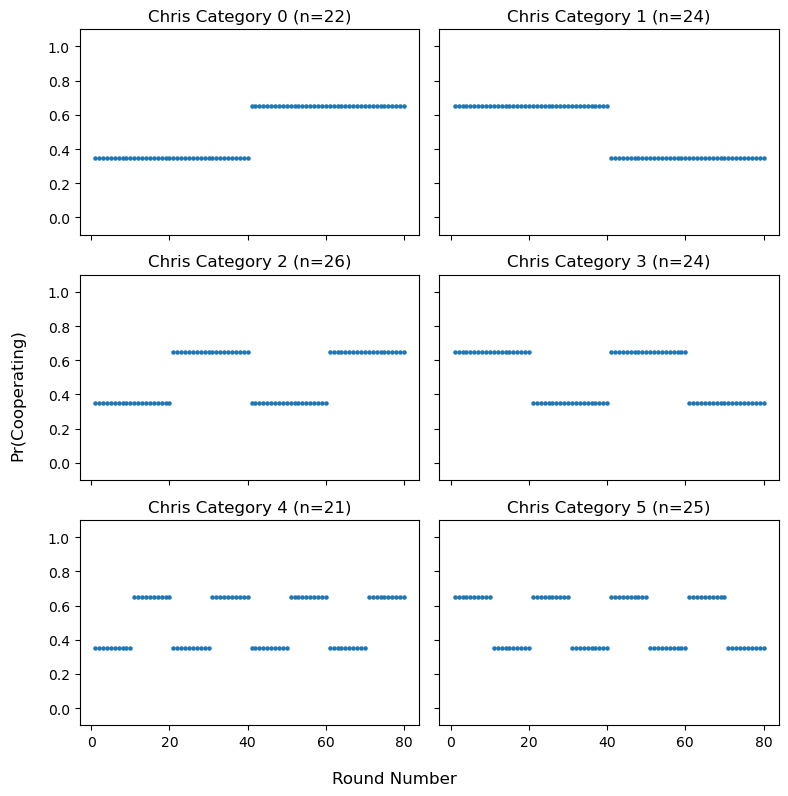

In [8]:
# Visalize chris category
fig, axs = plt.subplots(3, 2, figsize=(8, 8), sharex=True, sharey=True)
rounds = np.arange(1, 81)
for idx, ax in enumerate(axs.flatten()):
    if idx < len(chirs_categoty):
        ax.scatter(rounds, chirs_categoty[idx], s=5)
        ax.set_title(f'Chris Category {idx} (n={len(subjects_category[idx])})')
        ax.set_ylim(-0.1, 1.1)
    else:
        ax.axis('off')

fig.supxlabel('Round Number', fontsize=12)
fig.supylabel('Pr(Cooperating)', fontsize=12)

plt.tight_layout()
plt.show()

In [3]:
task_data.head()

,ppt_number,ppt_gender,condition,round_number,binary_classification,chris_prob,ppt_contrib,chris_contrib,ppt_RT,prediction_report,prediction_RT,chris_behavior,turing_test,ppt_payment,start_strategy,p1_choice,p2_choice
0,1,female,low_vol,1,False,0.35,20,20,3743.000,0.09,6695.0,neither,human,1.76,0,1,1
1,1,female,low_vol,2,False,0.35,20,0,1600.005,0.09,6695.0,neither,human,1.76,0,1,0
2,1,female,low_vol,3,False,0.35,0,0,1653.000,0.09,6695.0,neither,human,1.76,0,0,0
3,1,female,low_vol,4,False,0.35,0,20,1711.005,0.09,6695.0,neither,human,1.76,0,0,1
4,1,female,low_vol,5,False,0.35,20,0,1631.000,0.09,6695.0,neither,human,1.76,0,1,0


In [30]:
# Aggregate rounds into blocks of 10
block_size = 10
num_blocks = task_data['round_number'].max() // block_size
blocked_data = []
sub_list = task_data['ppt_number'].unique()

for sub_num in sub_list:
    sub_data = task_data[task_data['ppt_number'] == sub_num].copy()
    
    # Process each block
    for block in range(num_blocks):
        block_start = block * block_size + 1
        block_end = (block + 1) * block_size
        
        block_data = sub_data[(sub_data['round_number'] >= block_start) & (sub_data['round_number'] <= block_end)]
        
        if not block_data.empty:
            coop_rate = block_data['p1_choice'].mean()
            chris_coop_rate = block_data['p2_choice'].mean()
            subject_predict_chris_coop = block_data['prediction_report'].mean()
            
            blocked_data.append({
                'ppt_number': sub_num,
                'block_number': block + 1,
                'subject_coop_rate': coop_rate,
                'chris_coop_rate': chris_coop_rate,
                'subject_predict_chris_coop': subject_predict_chris_coop
            })

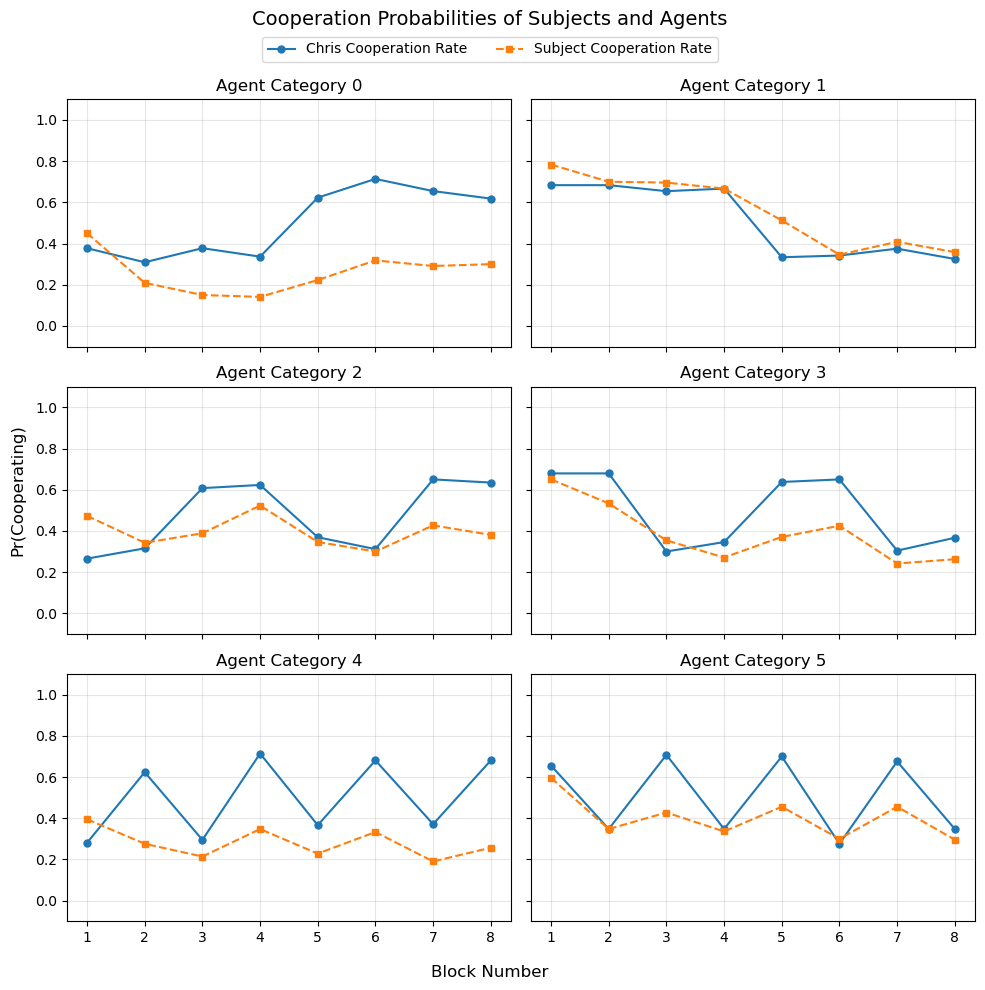

In [27]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)
rounds = np.arange(1, 81)

# Create handles for legend (will be created from first plot)
handles, labels = None, None

for idx, ax in enumerate(axs.flatten()):
    if idx < len(chirs_categoty):
        subjects = subjects_category[idx]
        chris_blocked_choice = defaultdict(list)
        subject_blocked_choice = defaultdict(list)
        for each in blocked_data:
            if each['ppt_number'] in subjects:
                chris_blocked_choice[each['block_number']].append(each['chris_coop_rate'])
                subject_blocked_choice[each['block_number']].append(each['subject_coop_rate'])

        blocks = sorted(chris_blocked_choice.keys())
        chris_blocked_choice = [np.mean(chris_blocked_choice[block]) for block in blocks]
        subject_blocked_choice = [np.mean(subject_blocked_choice[block]) for block in blocks]

        # Plot with markers
        line1 = ax.plot(blocks, chris_blocked_choice, marker='o', linestyle='-', 
                       label='Chris Cooperation Rate', markersize=5)
        line2 = ax.plot(blocks, subject_blocked_choice, marker='s', linestyle='--', 
                       label='Subject Cooperation Rate', markersize=5)
        
        # Get handles and labels from first plot
        if handles is None:
            handles, labels = ax.get_legend_handles_labels()
        
        ax.set_title(f'Agent Category {idx}')
        ax.set_ylim(-0.1, 1.1)
        ax.grid(True, alpha=0.3)
    else:
        ax.axis('off')

# Add single legend above the subplots
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.96), 
          frameon=True, fontsize=10)

fig.supxlabel('Block Number', fontsize=12)
fig.supylabel('Pr(Cooperating)', fontsize=12)
fig.suptitle('Cooperation Probabilities of Subjects and Agents', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for legend at top
plt.show()

In [20]:
# Get model prediction
fitted_params = pd.read_csv('PD_BRL_fitting_results.csv')
fitted_params.head()

,sub_num,betaParam,bias,gammaPos,gammaNeg,BayesLL,AIC
0,1,9.343734,0.478638,0.645417,0.619850,28.328629,-64.657258
1,3,20.000000,0.260063,0.808777,1.000000,9.750429,-27.500858
2,4,20.000000,0.276046,0.836880,1.000000,14.733745,-37.467490
3,5,20.000000,0.341111,0.687485,0.784389,9.503122,-27.006243
4,6,18.537097,0.100000,0.436827,0.955349,42.564273,-93.128547


In [21]:
brl_predictions = defaultdict(dict)
for _, row in fitted_params.iterrows():
    sub_num = row['sub_num']
    beta_param = row['betaParam']
    bias = row['bias']
    gamma_pos = row['gammaPos']
    gamma_neg = row['gammaNeg']
    
    sub_data = task_data[task_data['ppt_number'] == sub_num].copy()
    
    if not sub_data.empty:
        _, choice_probs, mews = pd_brl_loglikelihood(sub_data, beta_param, bias, gamma_pos, gamma_neg)
        
        brl_predictions[sub_num]['choice_probs'] = choice_probs
        brl_predictions[sub_num]['mews'] = mews

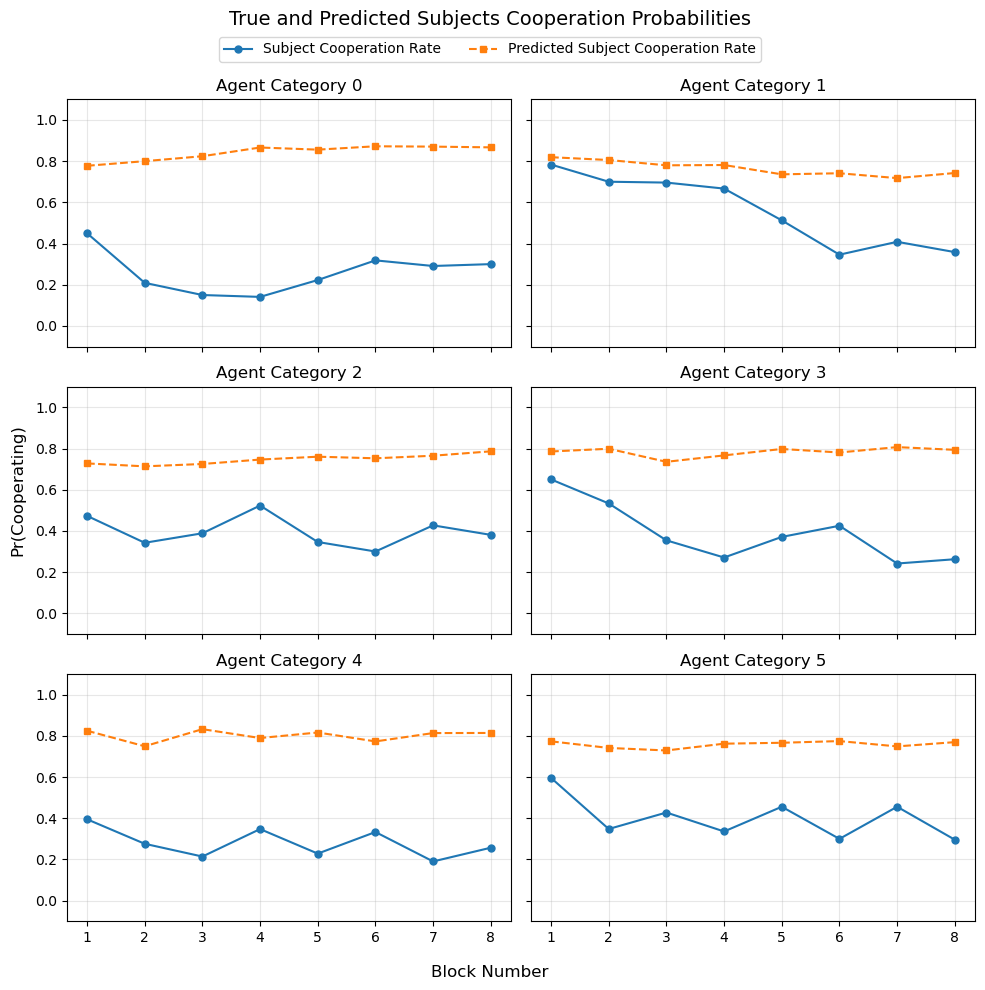

In [29]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)
rounds = np.arange(1, 81)

# Create handles for legend (will be created from first plot)
handles, labels = None, None

for idx, ax in enumerate(axs.flatten()):
    if idx < len(chirs_categoty):
        subjects = subjects_category[idx]
        subject_blocked_choice = defaultdict(list)
        for each in blocked_data:
            if each['ppt_number'] in subjects:
                subject_blocked_choice[each['block_number']].append(each['subject_coop_rate'])

        blocks = sorted(subject_blocked_choice.keys())
        subject_blocked_choice = [np.mean(subject_blocked_choice[block]) for block in blocks]

        # Get BRL predictions
        brl_blocked_choice = defaultdict(list)
        for sub, v in brl_predictions.items():
            if sub in subjects:
                choice_probs = v['choice_probs']
                # Aggregate into blocks
                for block in range(num_blocks):
                    block_start = block * block_size
                    block_end = (block + 1) * block_size
                    block_choice_probs = choice_probs[block_start:block_end]
                    mean_choice_prob = np.mean(block_choice_probs)
                    brl_blocked_choice[block + 1].append(mean_choice_prob)
        brl_blocked_choice = [np.mean(brl_blocked_choice[block]) for block in blocks]

        # Plot with markers
        line1 = ax.plot(blocks, subject_blocked_choice, marker='o', linestyle='-', 
                       label='Subject Cooperation Rate', markersize=5)
        line2 = ax.plot(blocks, brl_blocked_choice, marker='s', linestyle='--', 
                       label='Predicted Subject Cooperation Rate', markersize=5)
        
        # Get handles and labels from first plot
        if handles is None:
            handles, labels = ax.get_legend_handles_labels()
        
        ax.set_title(f'Agent Category {idx}')
        ax.set_ylim(-0.1, 1.1)
        ax.grid(True, alpha=0.3)
    else:
        ax.axis('off')

# Add single legend above the subplots
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.96), 
          frameon=True, fontsize=10)

fig.supxlabel('Block Number', fontsize=12)
fig.supylabel('Pr(Cooperating)', fontsize=12)
fig.suptitle('True and Predicted Subjects Cooperation Probabilities', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for legend at top
plt.show()

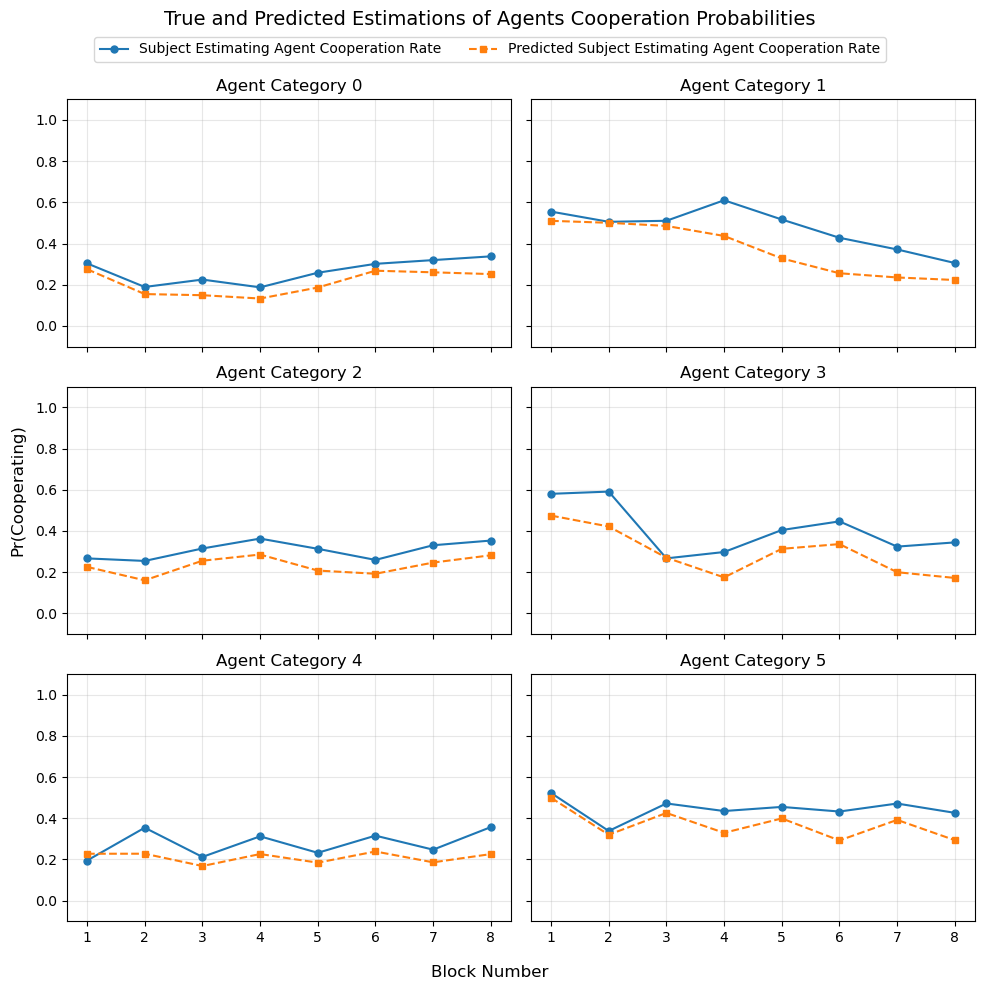

In [40]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)
rounds = np.arange(1, 81)

# Create handles for legend (will be created from first plot)
handles, labels = None, None

for idx, ax in enumerate(axs.flatten()):
    if idx < len(chirs_categoty):
        subjects = subjects_category[idx]
        subject_predict_choice = defaultdict(list)
        for each in blocked_data:
            if each['ppt_number'] in subjects:
                subject_predict_choice[each['block_number']].append(each['subject_predict_chris_coop'])

        blocks = sorted(subject_predict_choice.keys())
        subject_predict_choice = [np.mean(subject_predict_choice[block]) for block in blocks]

        # Get BRL predictions
        brl_mews = defaultdict(list)
        for sub, v in brl_predictions.items():
            if sub in subjects:
                mews = v['mews']
                # Aggregate into blocks
                for block in range(num_blocks):
                    block_start = block * block_size
                    block_end = (block + 1) * block_size
                    block_mews = mews[block_start:block_end]
                    mean_mews = np.mean(block_mews)
                    brl_mews[block + 1].append(mean_mews)
        brl_mews = [np.mean(brl_mews[block]) for block in blocks]

        # Plot with markers
        line1 = ax.plot(blocks, subject_predict_choice, marker='o', linestyle='-', 
                       label='Subject Estimating Agent Cooperation Rate', markersize=5)
        line2 = ax.plot(blocks, brl_mews, marker='s', linestyle='--', 
                       label='Predicted Subject Estimating Agent Cooperation Rate', markersize=5)
        
        # Get handles and labels from first plot
        if handles is None:
            handles, labels = ax.get_legend_handles_labels()
        
        ax.set_title(f'Agent Category {idx}')
        ax.set_ylim(-0.1, 1.1)
        ax.grid(True, alpha=0.3)
    else:
        ax.axis('off')

# Add single legend above the subplots
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.96), 
          frameon=True, fontsize=10)

fig.supxlabel('Block Number', fontsize=12)
fig.supylabel('Pr(Cooperating)', fontsize=12)
fig.suptitle('True and Predicted Estimations of Agents Cooperation Probabilities', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for legend at top
plt.show()

In [41]:
brl_predictions

defaultdict(dict,
            {np.float64(1.0): {'choice_probs': array([0.54973452, 0.86176956, 0.55783629, 0.83801011, 0.68760379,
                     0.73612931, 0.22847605, 0.06783699, 0.02968522, 0.33141971,
                     0.25134292, 0.90568275, 0.95388398, 0.97159254, 0.97939047,
                     0.98330334, 0.98544703, 0.33392337, 0.81500661, 0.94297819,
                     0.55687209, 0.88230078, 0.56551225, 0.84935796, 0.31014465,
                     0.74132979, 0.90439543, 0.38037502, 0.77901703, 0.91563702,
                     0.95749259, 0.97314591, 0.42010689, 0.84549304, 0.61971403,
                     0.86821816, 0.94211621, 0.96701938, 0.97728575, 0.98221463,
                     0.9848384 , 0.98633334, 0.32636477, 0.81215676, 0.94240453,
                     0.55487556, 0.80551373, 0.92306695, 0.41567628, 0.79505497,
                     0.9203493 , 0.5916028 , 0.89248142, 0.96026788, 0.61976525,
                     0.89733989, 0.96115383, 0.97913481, 0